In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [108]:
import numpy as np
import plotly.express as px
import pandas as pd
from collections.abc import Iterable
from typing import Tuple, List
from matplotlib import pyplot

# Allan Variance

This notebook builds on [1] to cover some calculations and definitions for empircally calculating an Allan variance, and hence Allan deviation (the deviation being the square root of the variance).

## Preliminary algebra

This section builds on top of the algebra in [1], filling in a few gaps. The starting place is an oscillator, whose phase tracks time. This phase can be written as

\begin{equation*}
\Phi (t) := 2 \pi \nu_n (t + x(t))
\label{eq:phi-noise} \tag{1}
\end{equation*}

where $\nu_n$ is a 'nominal' frequency, $t$ is the ongoing actual time, and $x(t)$ is a phase noise term modelling the phase noise of the oscillator generating a timing signal. One can then define a dynamic frequency, $\nu (t)$, from the phase as

\begin{equation*}
\nu (t) := \frac{1}{2 \pi} \dot{\Phi} (t) = \nu_n ( 1 + \dot{x}(t) )
\end{equation*}

and a 'fractional frequency' $y(t)$ as

\begin{equation*}
y (t) := \frac{\nu(t) - \nu_n}{\nu_n} = \dot{x} (t)
\end{equation*}

from which one can deduce a form, in terms of $x$, for the 'average fractional frequency', $\bar{y}$, as

\begin{equation*}
\bar{y} (t, \tau) := \frac{1}{\tau} \int_0^\tau y(t+s)ds = \frac{x(t+\tau) - x(t)}{\tau}
\end{equation*}

Using the definition on [1] for the M-sample Allan variance, $\sigma_y^2(M, T, \tau)$,

\begin{equation*}
\sigma_y^2(M, T, \tau) = \frac{1}{M - 1} \left\{\sum_{i=0}^{M-1}\left[\frac{x(iT + \tau) - x(iT)}{\tau}\right]^2 - \frac{1}{M} \left[\sum_{i=0}^{M-1}\frac{x(iT + \tau) - x(iT)}{\tau}\right]^2\right\}
\end{equation*}

one can introduce notation for a discrete form of the average fractional frequency, $\bar{y}(t)$ as

\begin{equation*}
\bar{y_i} = \frac{x(iT+\tau) - x(iT)}{\tau}
\end{equation*}

which simplifies the expression for the M-sample Allan variance

\begin{equation*}
\sigma_y^2(M, T, \tau) = \frac{1}{M - 1} \left\{\sum_{i=0}^{M-1}\bar{y}_i^2 - \frac{1}{M} \left[ \sum_{i=0}^{M-1} \bar{y}_i\right]^2 \right\}
\end{equation*}


The 2-sample no dead-time Allan Variance is given by (introducing the shorthand $x_i = x(i\tau )$, which makes sense here since $T = \tau $)

\begin{equation*}
\sigma_y^2(\tau) = \sigma_y^2(2, \tau, \tau) = \sum_{i=0}^1 \bar{y}_i^2 - \frac{1}{2}\left[\sum_{i=0}^1 \bar{y}_i\right]^2 \\
= \frac{1}{2} (\bar{y}_{i+1} - \bar{y}_i)^2 \big|_{i=0} \\
= \frac{1}{2\tau^2}(x_{i+2} - 2x_{i+1} + x_i) \big|_{i=0} \\
= \frac{1}{2\tau^2}\big(x((i+2)\tau) - 2x((i+1)\tau) + x(i\tau) \big) \big|_{i=0}
\end{equation*}

The $i$s have been left in above, with the $i$s at zero. Often in the definition of a 2-sample Allan deviation, the notation is abused and $i$s are left in, even though they should be set to zero. The condition of $|_{i=0}$ should help to alleviate that confusion whilst maintaining consistency with the standard abuse of notation.

On a time series $\{x_i\}$ with interval $\tau$, one can then define an estimator for the 2-sample Allan variance as

\begin{equation*}
\operatorname{AVAR}(\tau, N) = \frac{1}{2\tau^2(N - 2)} \sum_{i=0}^{N-3}(x_{i+2} - 2x_{i+1} + x_i)^2
\end{equation*}

This equation uses a single time series to calculate an estimate for an Allan deviation where $\tau$ is given by the sample interval. The same time series can be used to calculate multiple estimates at different $\tau$, by considering $n\tau_0 = \tau$, where the time series $\{x_i\}$ has sample interval $\tau_0$

\begin{equation*}
\operatorname{AVAR}(n\tau_0, N) = \frac{1}{2n^2\tau_0^2(N - 2n)} \sum_{i=0}^{N-2n-1} (x_{i+2n} - 2x_{i+n} + x_i)^2
\label{eq:avar-calc} \tag{2}
\end{equation*}

This defintion of AVAR is adopted by IEEE, ITU-T and ETSI [1].

## Python implementation


In [78]:
def avar_sum(x: Iterable[float], stride: float) -> float:
    """ represents the summation in equation (2)

        x: the array in the summation
        stride: the 'n' in the summation of equation (2)
        
        returns the result of the summation in equation (2)
    """
    s = 0.0
    n_sum = len(x) - 2 * stride - 1
    for ctr in range(n_sum):
        s += (x[ctr + 2*stride] - 2 * x[ctr + stride] + x[ctr]) ** 2
    return s

def avar_sum_numpy(x: Iterable[float], stride: float) -> float:
    """ same as avar_sum, but sped up using numpy arrays """
    n_sum = len(x) - 2 * stride - 1
    cache = np.array([
        x[:n_sum],
        x[stride:n_sum + stride],
        x[2 * stride:n_sum + 2 * stride]
    ])
    cache[1] *= -2.0
    s = np.sum(np.square(np.sum(cache, axis=0)))
    return s
    
    
def avar(
    data: Iterable[float], 
    sample_interval_secs: float,
    n_min: int=1,
    n_max: int=None
) -> Tuple[List[float], List[float]]:
    """ Calculates the result of equation (2) for multiple 'n'
    
        data: time series data to calculate AVAR over
        sample_interval_secs: sample interval of the time series, in seconds
        n_min: put a floor on the 'n' for calculating AVARs. Defaults to 1.
        n_max: put a ceiling on the 'n' for calculating AVARs. If None, the max 'n' will be used
        
        returns 2 lists, the first being the taus used (n tau_0), the second being the AVARs
    """
    taus = []
    avars = []
    n_sample = len(data)
    tau0 = sample_interval_secs
    n_max_on_tau0 = int((n_sample - 1) / 2) - 1
    if n_max is not None:
        n_max_on_tau0 = min(n_max_on_tau0, n_max)
    for n_on_tau0 in range(n_min, n_max_on_tau0):
        tau = n_on_tau0 * tau0
        s = avar_sum_numpy(data, n_on_tau0) / (2.0 * tau ** 2 * (n_sample - 2 * n_on_tau0))
        taus.append(tau)
        avars.append(s)
    return taus, avars

## Data examples

Following [2], one can generate some synthetic data for testing.

The example below is a simple example (and perhaps not the best suited to Allan statistics, but good for diagnostic purposes

Text(0.5, 0, 'time (seconds)')

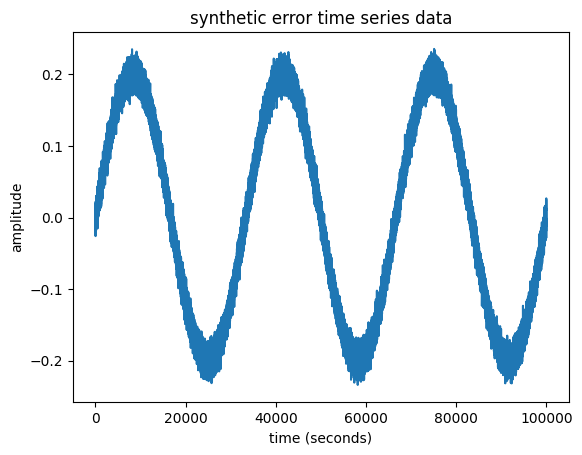

In [134]:
n = int(1e5)
sample_interval_secs = 1.0e-3
sine_wave_hertz = 0.00003
sine_wave_amplitude = 0.2
# Gaussian random noise on top of a sine wave
data = np.random.normal(loc=0, scale=0.01, size=n) + \
    sine_wave_amplitude * np.sin(np.arange(n) * 2.0 * np.pi * sample_interval * sine_wave_hertz)
pyplot.plot(np.arange(len(data)) * sample_interval, data)
pyplot.title("synthetic error time series data")
pyplot.ylabel("amplitude")
pyplot.xlabel("time (seconds)")

In [135]:
taus, avars = avar(data, sample_interval, n_min=1, n_max=None)

Text(0.5, 1.0, 'Allan variance on synthetic data')

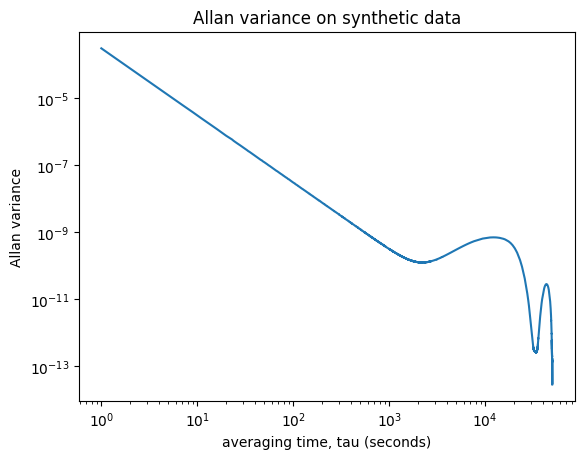

In [136]:
pyplot.loglog(taus, avars)
pyplot.xlabel("averaging time, tau (seconds)")
pyplot.ylabel("Allan variance")
pyplot.title("Allan variance on synthetic data")

In [137]:
df = pd.DataFrame({'averaging time, tau (seconds)': taus, 'Allan variance': avars})
px.line(df, x='averaging time, tau (seconds)', y='Allan variance', title='Allan variance on synthetic data', log_x=True, log_y=True)

## References

[1] Allan Variance. Wikipedia. https://en.wikipedia.org/wiki/Allan_variance (accessed 24 June 2023)

[2] Allan Variance in Python. Towards Data Science. https://towardsdatascience.com/allan-variance-in-python-d1175e5aeee2 (accessed 24 June 2023)